### Integrantes

- Juan José Naranjo Velasquez 
- Diego Alejandro Mora Suarez
- Kenneth David Leonel Triana

Dependencias

In [2]:
import pandas as pd
import numpy as np
#Libreria para ignorar warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

d:\programasProgramacion\anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Importar base de datos

In [3]:
datosAerolineas = pd.read_excel("data/EastWestAirlines.xlsx", engine="openpyxl", sheet_name="data")
datosAerolineas.head()

ID#  Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    1    28143           0          1          1          1          174   
1    2    19244           0          1          1          1          215   
2    3    41354           0          1          1          1         4123   
3    4    14776           0          1          1          1          500   
4    5    97752           0          4          1          1        43300   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  Award?  
0            1                  0                0               7000       0  
1            2                  0                0               6968       0  
2            4                  0                0               7034       0  
3            1                  0                0               6952       0  
4           26               2077                4               6935       1

###  Limpieza de los datos de la aérolinea

Revisión de nulos

In [4]:
#Revisar que no tengan datos nulos los campos de la aérolinea

datosAerolineas.isnull().sum()


ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

In [5]:
#Revisar datos máximos y minimos con el método describe
datosAerolineas.describe()

ID#       Balance    Qual_miles    cc1_miles    cc2_miles  \
count  3999.000000  3.999000e+03   3999.000000  3999.000000  3999.000000   
mean   2014.819455  7.360133e+04    144.114529     2.059515     1.014504   
std    1160.764358  1.007757e+05    773.663804     1.376919     0.147650   
min       1.000000  0.000000e+00      0.000000     1.000000     1.000000   
25%    1010.500000  1.852750e+04      0.000000     1.000000     1.000000   
50%    2016.000000  4.309700e+04      0.000000     1.000000     1.000000   
75%    3020.500000  9.240400e+04      0.000000     3.000000     1.000000   
max    4021.000000  1.704838e+06  11148.000000     5.000000     3.000000   

         cc3_miles    Bonus_miles  Bonus_trans  Flight_miles_12mo  \
count  3999.000000    3999.000000   3999.00000        3999.000000   
mean      1.012253   17144.846212     11.60190         460.055764   
std       0.195241   24150.967826      9.60381        1400.209171   
min       1.000000       0.000000      0.00000           0.000000   
25%       1.000000    1250.000000      3.00000           0.000000   
50%       1.000000    7171.000000     12.00000           0.000000   
75%       1.000000   23800.500000     17.00000         311.000000   
max       5.000000  263685.000000     86.00000       30817.000000   

       Flight_trans_12  Days_since_enroll       Award?  
count      3999.000000         3999.00000  3999.000000  
mean          1.373593         4118.55939     0.370343  
std           3.793172         2065.13454     0.482957  
min           0.000000            2.00000     0.000000  
25%           0.000000         2330.00000     0.000000  
50%           0.000000         4096.00000     0.000000  
75%           1.000000         5790.50000     1.000000  
max          53.000000         8296.00000     1.000000

Al analizar los datos se determina que el campo ID no es relevante ese identificadro unico para todo el proceso de clusterización

In [6]:
#Eliminar columna ID
datosAerolineas = datosAerolineas.drop(columns="ID#")
#Dejar para manipular más facil los datos dejar las columna en minuscula
datosAerolineas.columns = datosAerolineas.columns.str.lower()
#Renombrar columna award para que no quede con el simbolo de pregunta 
datosAerolineas.rename(columns={"award?": "award"}, inplace=True)
datosAerolineas.head()

balance  qual_miles  cc1_miles  cc2_miles  cc3_miles  bonus_miles  \
0    28143           0          1          1          1          174   
1    19244           0          1          1          1          215   
2    41354           0          1          1          1         4123   
3    14776           0          1          1          1          500   
4    97752           0          4          1          1        43300   

   bonus_trans  flight_miles_12mo  flight_trans_12  days_since_enroll  award  
0            1                  0                0               7000      0  
1            2                  0                0               6968      0  
2            4                  0                0               7034      0  
3            1                  0                0               6952      0  
4           26               2077                4               6935      1

### Escalar los datos

In [7]:
#Se escalan los datos ya que hay unas feature donde sus valores son muy altos 
scaler = MinMaxScaler()
datosAerolineas_escalados = scaler.fit_transform(datosAerolineas)
datosAerolineas_escalados = pd.DataFrame(datosAerolineas_escalados, columns=datosAerolineas.columns)
datosAerolineas_escalados.head()

balance  qual_miles  cc1_miles  cc2_miles  cc3_miles  bonus_miles  \
0  0.016508         0.0       0.00        0.0        0.0     0.000660   
1  0.011288         0.0       0.00        0.0        0.0     0.000815   
2  0.024257         0.0       0.00        0.0        0.0     0.015636   
3  0.008667         0.0       0.00        0.0        0.0     0.001896   
4  0.057338         0.0       0.75        0.0        0.0     0.164211   

   bonus_trans  flight_miles_12mo  flight_trans_12  days_since_enroll  award  
0     0.011628           0.000000         0.000000           0.843742    0.0  
1     0.023256           0.000000         0.000000           0.839884    0.0  
2     0.046512           0.000000         0.000000           0.847842    0.0  
3     0.011628           0.000000         0.000000           0.837955    0.0  
4     0.302326           0.067398         0.075472           0.835905    1.0

Visualizar datos

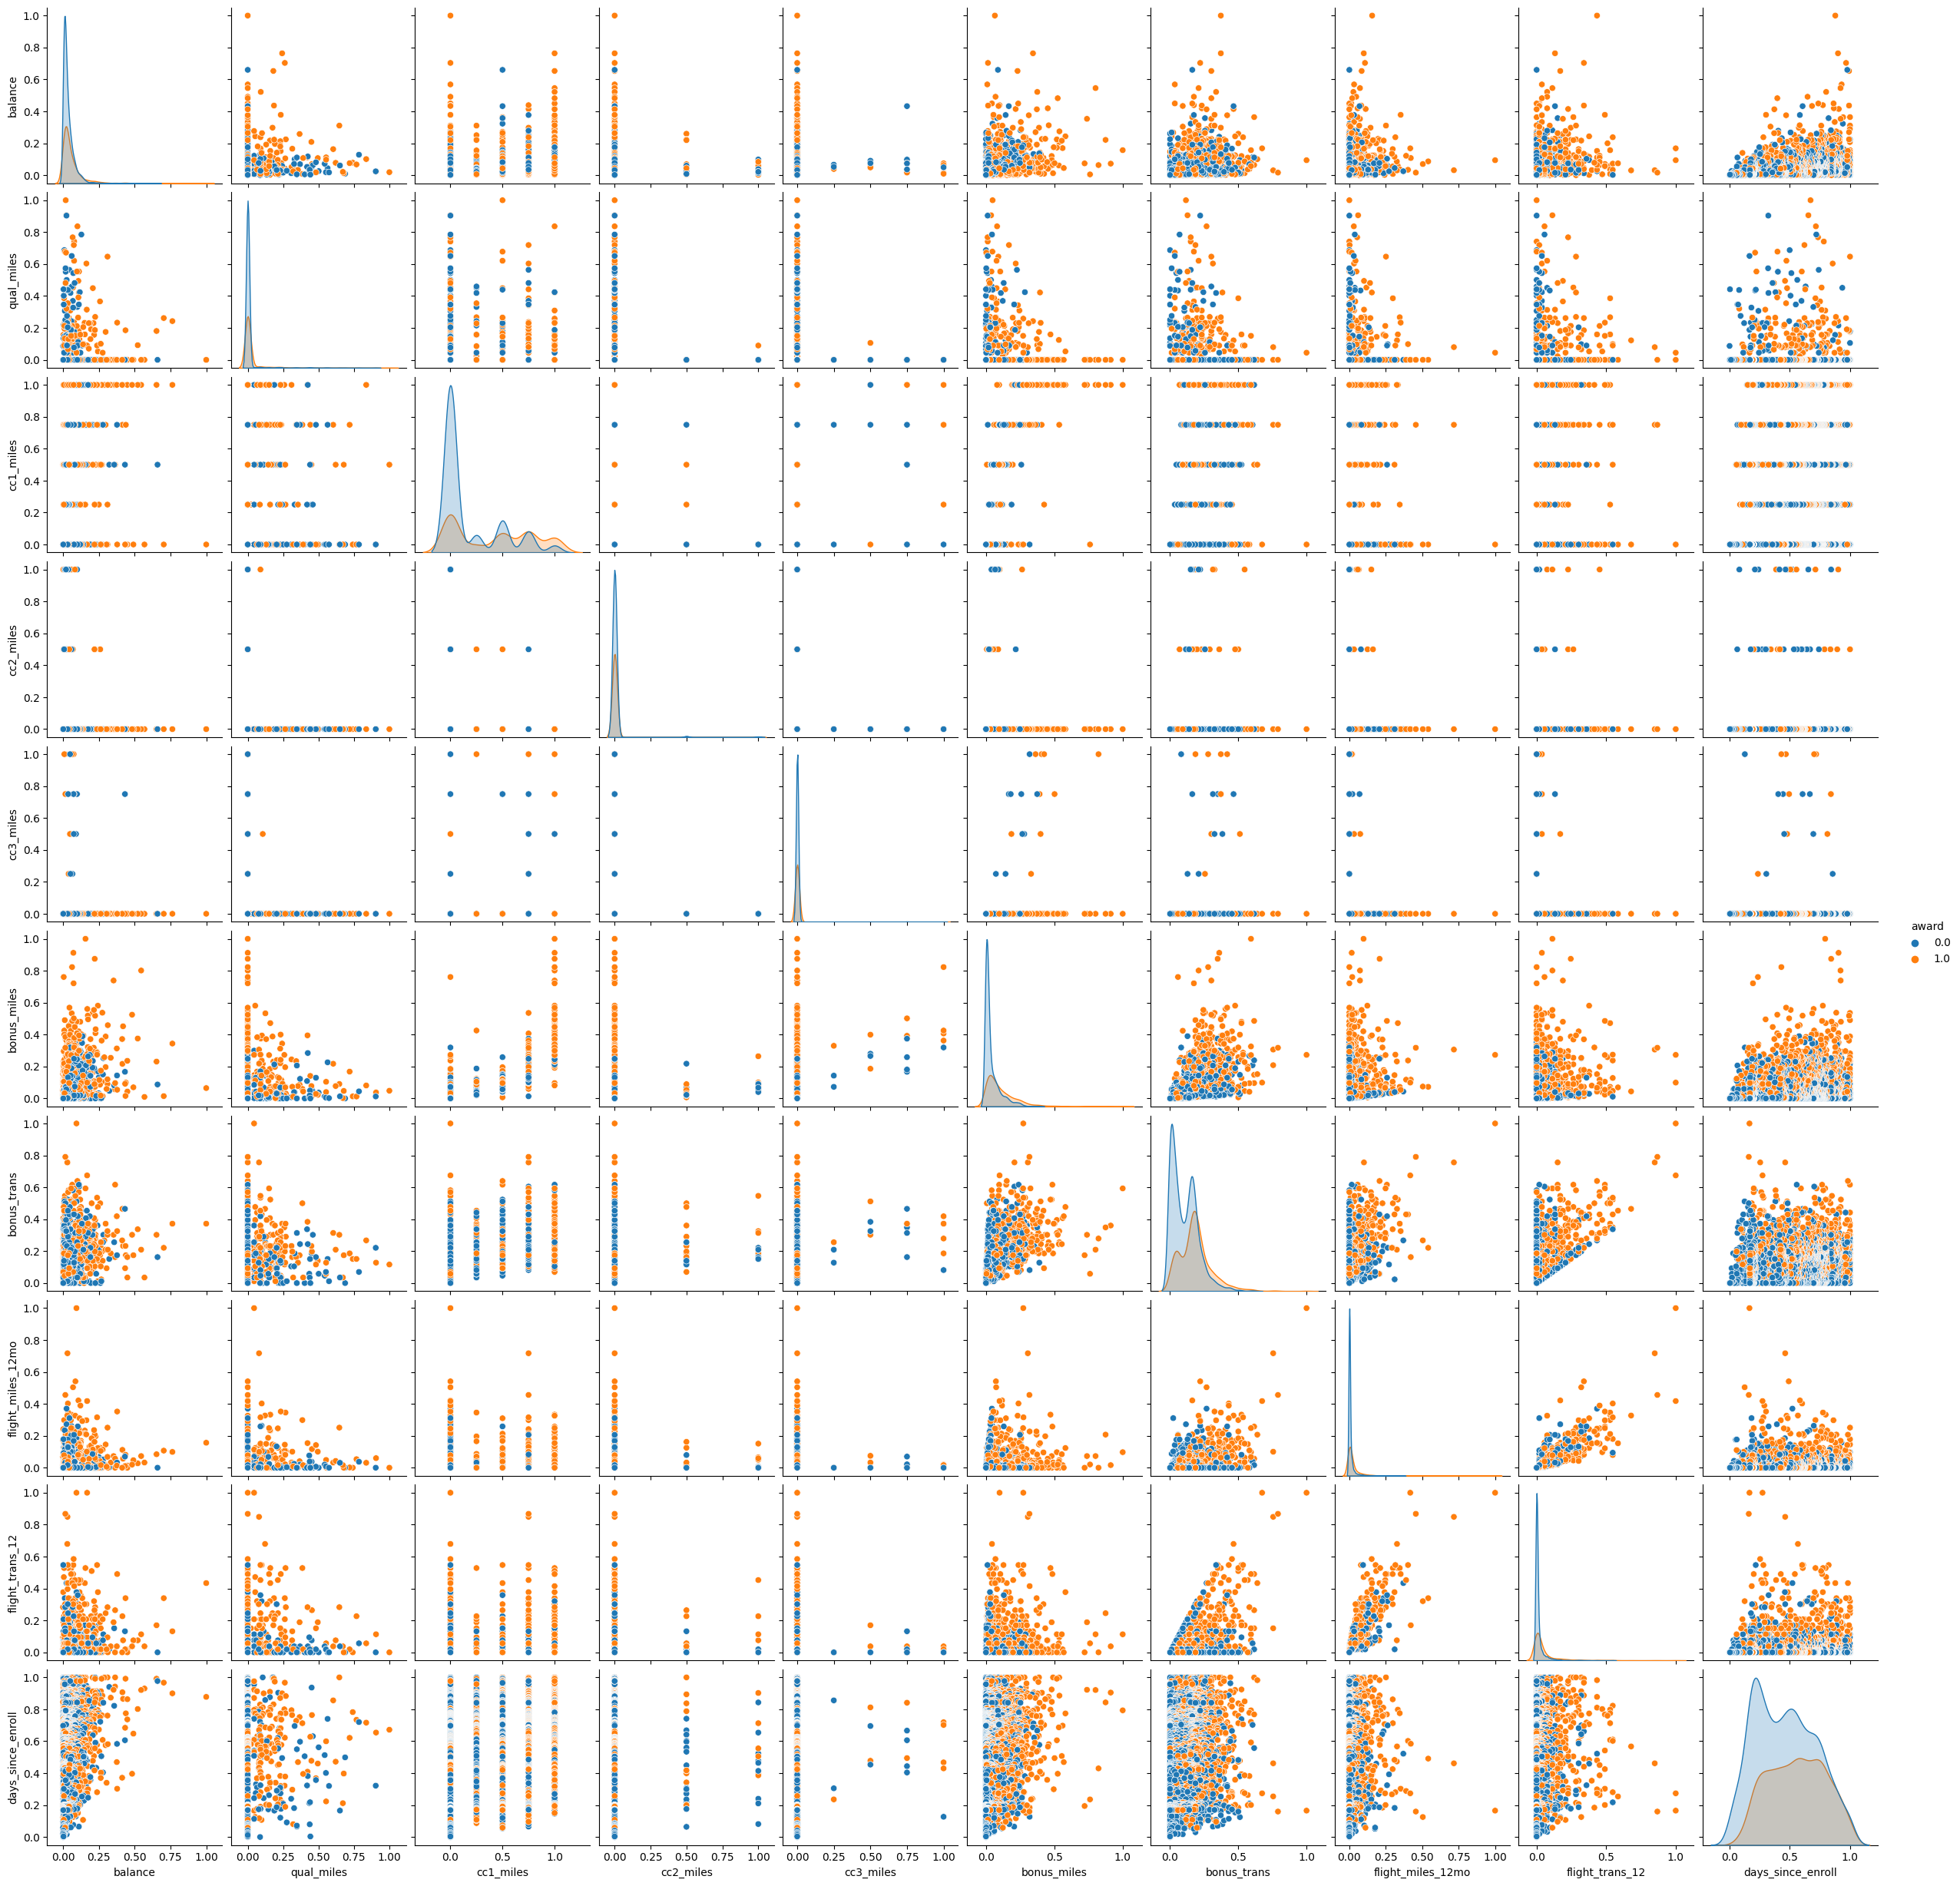

In [8]:
sns.pairplot(datosAerolineas_escalados, hue='award')

Después de ver los resultados podemos ver que las características qual_miles y days_since_enroll son las qeu detallan una mejor dispersión de los datos ya que las otras se ven muy agrupados.

In [9]:
datosAerolineas_escalados.head()

balance  qual_miles  cc1_miles  cc2_miles  cc3_miles  bonus_miles  \
0  0.016508         0.0       0.00        0.0        0.0     0.000660   
1  0.011288         0.0       0.00        0.0        0.0     0.000815   
2  0.024257         0.0       0.00        0.0        0.0     0.015636   
3  0.008667         0.0       0.00        0.0        0.0     0.001896   
4  0.057338         0.0       0.75        0.0        0.0     0.164211   

   bonus_trans  flight_miles_12mo  flight_trans_12  days_since_enroll  award  
0     0.011628           0.000000         0.000000           0.843742    0.0  
1     0.023256           0.000000         0.000000           0.839884    0.0  
2     0.046512           0.000000         0.000000           0.847842    0.0  
3     0.011628           0.000000         0.000000           0.837955    0.0  
4     0.302326           0.067398         0.075472           0.835905    1.0

In [10]:
# Seleccionemos como prueba los features 1, 9 que son las que mejor dispersión tiene en la gráfica anterior
X_2d = datosAerolineas_escalados.iloc[:,[1,9]]
X_2d

qual_miles  days_since_enroll
0            0.0           0.843742
1            0.0           0.839884
2            0.0           0.847842
3            0.0           0.837955
4            0.0           0.835905
...          ...                ...
3994         0.0           0.168917
3995         0.0           0.167953
3996         0.0           0.168797
3997         0.0           0.168676
3998         0.0           0.168314

[3999 rows x 2 columns]

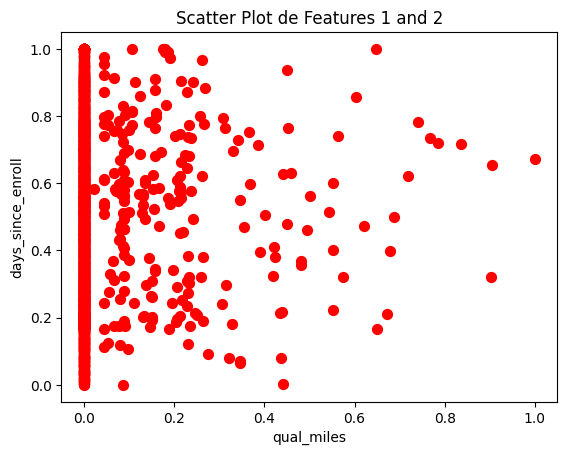

In [11]:
plt.scatter(X_2d.iloc[:,0], X_2d.iloc[:,1], marker='o', color='r', s=50)
plt.xlabel('qual_miles')
plt.ylabel('days_since_enroll')
plt.title('Scatter Plot de Features 1 and 2')
plt.show()

Se empieza a evaluar los parámetros 

In [12]:
# Inicializar aleatoriamente los theta_old
# Fija el número de clusters K = 3
np.random.seed(42)
pi1 = 0.33
pi2 = 0.33
pi3 = 0.33
mu_1 = np.random.randn(2,) + np.reshape([0,0.7],(2,))
mu_2 = np.random.randn(2,) + np.reshape([0.5,0.2],(2,))
mu_3 = np.random.randn(2,) + np.reshape([0.5,0.7],(2,))

In [13]:
aux = np.random.randn(2,2)
print(aux)
print(aux.T)
print(aux.T@aux)

[[ 1.57921282  0.76743473]
 [-0.46947439  0.54256004]]
[[ 1.57921282 -0.46947439]
 [ 0.76743473  0.54256004]]
[[2.71431932 0.95722472]
 [0.95722472 0.88332746]]


In [14]:
aux = np.random.randn(2,2)
Sigma_1 =0.01*aux.T@aux
aux2 = np.random.randn(2,2)
Sigma_2 = 0.2*aux2.T@aux2
aux3 = np.random.randn(2,2)
Sigma_3 = 0.01*aux3.T@aux3
print(Sigma_1, np.linalg.det(Sigma_1))
print(Sigma_2, np.linalg.det(Sigma_2))
print(Sigma_3, np.linalg.det(Sigma_3))


[[ 0.00273302 -0.00247114]
 [-0.00247114  0.03877545]] 9.98674331226338e-05
[[0.80023368 0.13032406]
 [0.13032406 0.08298373]] 0.04942201496645322
[[0.02972634 0.00951497]
 [0.00951497 0.02045577]] 0.000517540431702083


Ya que al ver los resultados de nuestras matrices de covarianzas y ver el determinate que apesar de que sean pequños no son negativos

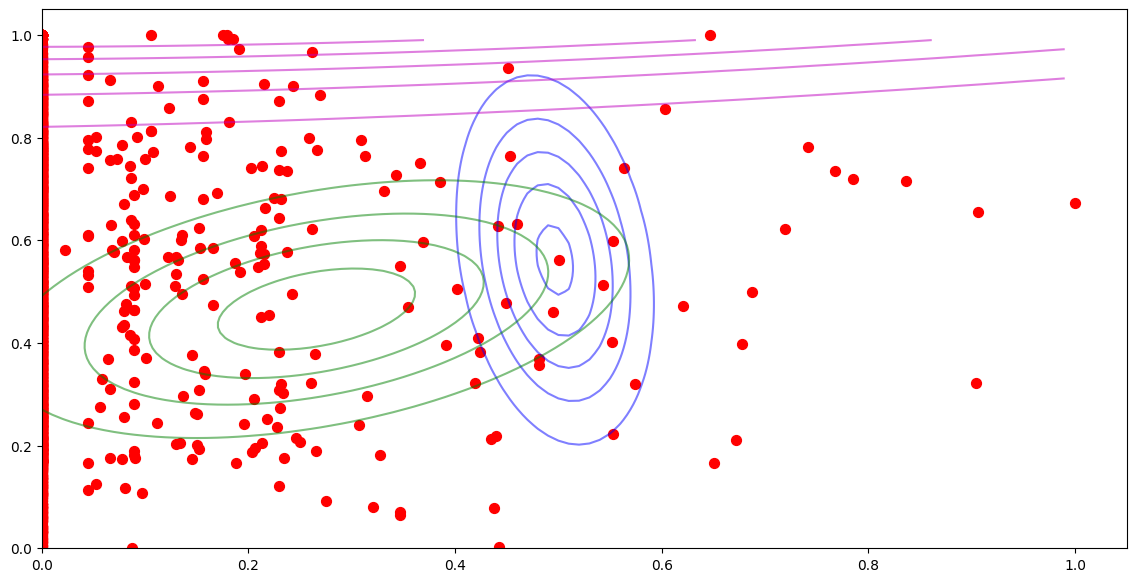

In [15]:
# Graficamos el ajuste inicial
# Se crea la matriz de datos
x, y = np.mgrid[0:1:.01, 0:1:.01]
pos = np.dstack((x, y))

# Calculate the Gaussian probability density function for each class
rv1 = multivariate_normal(mu_1, Sigma_1)
rv2 = multivariate_normal(mu_2, Sigma_2)
rv3 = multivariate_normal(mu_3, Sigma_3)
z1 = rv1.pdf(pos)
z2 = rv2.pdf(pos)
z3 = rv3.pdf(pos)

# Plot the Gaussian distributions
plt.figure(figsize=(14, 7))
plt.contour(x, y, z1, levels=5, colors='b', alpha=0.5)
plt.contour(x, y, z2, levels=5, colors='m', alpha=0.5)
plt.contour(x, y, z3, levels=5, colors='g', alpha=0.5)
plt.scatter(X_2d.iloc[:,0], X_2d.iloc[:,1], marker='o', color='r', s=50)


In [16]:
gama_Znk = np.zeros((X_2d.shape[0],3)) # Matriz de responsabilidades o Posterior P(zn|xn)

for n in range(X_2d.shape[0]):
  x_n = X_2d.iloc[n,:]
  for k in range(3):
    if k == 0:
      gama_Znk[n,k] = pi1 * multivariate_normal.pdf(x_n, mu_1, Sigma_1)/(pi1 * rv1.pdf(x_n) + pi2 * rv2.pdf(x_n) + pi3 * rv3.pdf(x_n))
    if k == 1:
      gama_Znk[n,k] = pi2 * multivariate_normal.pdf(x_n, mu_2, Sigma_2)/(pi1 * rv1.pdf(x_n) + pi2 * rv2.pdf(x_n) + pi3 * rv3.pdf(x_n))
    if k == 2:
      gama_Znk[n,k] = pi3 * multivariate_normal.pdf(x_n, mu_3, Sigma_3)/(pi1 * rv1.pdf(x_n) + pi2 * rv2.pdf(x_n) + pi3 * rv3.pdf(x_n))

print(gama_Znk)

[[2.46282461e-17 5.89247069e-01 4.10752931e-01]
 [2.37374362e-17 5.53620208e-01 4.46379792e-01]
 [2.54698753e-17 6.26251252e-01 3.73748748e-01]
 ...
 [4.14183438e-23 1.43160588e-07 9.99999857e-01]
 [4.13641115e-23 1.42988744e-07 9.99999857e-01]
 [4.12019482e-23 1.42474960e-07 9.99999858e-01]]


In [17]:
len(X_2d)

3999

In [18]:
X_2d.columns

Index(['qual_miles', 'days_since_enroll'], dtype='object')

In [19]:
# Construirmos el modelo discriminante
#Se tiene en cuenta que nuestro dataset es de 3999 por eso N1,N2 y N3 tienen el valor de 1333
N1, N2, N3 = 1333,1333,1333
N = N1+N2+N3
piC1 = N1/N
piC2 = N2/N
piC3 = N3/N

X_d2 = X_2d

X_C1 = X_d2.iloc[:1333,:]
X_C2 = X_d2.iloc[1333:2666,:]
X_C3 = X_d2.iloc[2666:,:]

muC1 = np.mean(X_C1, axis=0)
muC2 = np.mean(X_C2, axis=0)
muC3 = np.mean(X_C3, axis=0)

M1 = np.tile(muC1, (N1,1))
M2 = np.tile(muC2, (N2,1))
M3 = np.tile(muC3, (N3,1))

S1 = (1./N1) * (X_C1 - M1).T.dot(X_C1 - M1)
S2 = (1./N2) * (X_C2 - M2).T.dot(X_C2 - M2)
S3 = (1./N3) * (X_C3 - M3).T.dot(X_C3 - M3)

Sigma = (N1/N)*S1 + (N2/N)*S2 + (N3/N)*S3

In [20]:
w_C1 = np.linalg.inv(Sigma).dot(muC1)
w_C2 = np.linalg.inv(Sigma).dot(muC2)
w_C3 = np.linalg.inv(Sigma).dot(muC3)

w_10 = -0.5 * (muC1.T.dot(np.linalg.inv(Sigma)).dot(muC1)) + np.log(piC1)
w_20 = -0.5 * (muC2.T.dot(np.linalg.inv(Sigma)).dot(muC2))+ np.log(piC2)
w_30 = -0.5 * (muC3.T.dot(np.linalg.inv(Sigma)).dot(muC3))+ np.log(piC3)

A1 = w_C1.T.dot(X_d2.T) + w_10
A2 = w_C2.T.dot(X_d2.T) + w_20
A3 = w_C3.T.dot(X_d2.T) + w_30

A = np.vstack((A1,A2,A3)).T

In [21]:
postCk = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
postCk

array([[9.98277230e-01, 1.72276643e-03, 3.46552394e-09],
       [9.98064218e-01, 1.93577739e-03, 4.31793133e-09],
       [9.98477972e-01, 1.52202548e-03, 2.74335336e-09],
       ...,
       [5.40144848e-09, 6.96003614e-03, 9.93039958e-01],
       [5.36454014e-09, 6.93775259e-03, 9.93062242e-01],
       [5.25531914e-09, 6.87132614e-03, 9.93128669e-01]])

In [22]:
Sigma

qual_miles  days_since_enroll
qual_miles           0.004813          -0.000049
days_since_enroll   -0.000049           0.009802

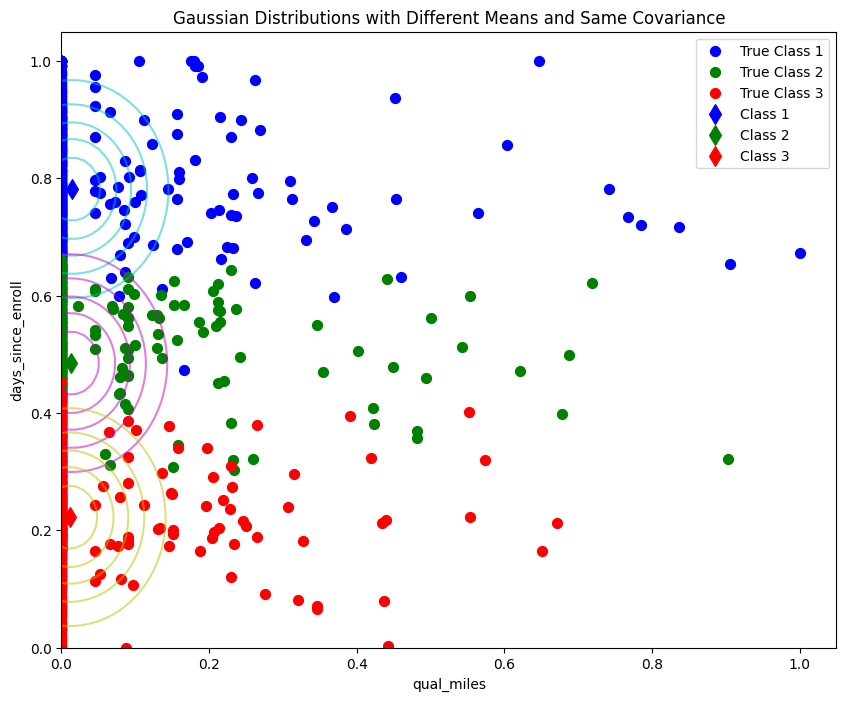

In [23]:
# Create a grid of points
x, y = np.mgrid[0:1:.01, 0:1:.01] 
pos = np.dstack((x, y))

# Calculate the Gaussian probability density function for each class
rv1 = multivariate_normal(muC1, Sigma)
rv2 = multivariate_normal(muC2, Sigma)
rv3 = multivariate_normal(muC3, Sigma)
z1 = rv1.pdf(pos)
z2 = rv2.pdf(pos)
z3 = rv3.pdf(pos)

# Plot the Gaussian distributions
plt.figure(figsize=(10, 8))
plt.contour(x, y, z1, levels=5, colors='c', alpha=0.5)
plt.contour(x, y, z2, levels=5, colors='m', alpha=0.5)
plt.contour(x, y, z3, levels=5, colors='y', alpha=0.5)

# Plot the means of each class
plt.scatter(X_C1.iloc[:,0], X_C1.iloc[:,1], marker='o', color='b', s=50, label='True Class 1')
plt.scatter(X_C2.iloc[:,0], X_C2.iloc[:,1], marker='o', color='g', s=50, label='True Class 2')
plt.scatter(X_C3.iloc[:,0], X_C3.iloc[:,1], marker='o', color='r', s=50, label='True Class 3')

plt.scatter(muC1[0], muC1[1], marker='d', color='b', s=100, label='Class 1')
plt.scatter(muC2[0], muC2[1], marker='d', color='g', s=100, label='Class 2')
plt.scatter(muC3[0], muC3[1], marker='d', color='r', s=100, label='Class 3')

plt.xlabel('qual_miles')
plt.ylabel('days_since_enroll')
plt.title('Gaussian Distributions with Different Means and Same Covariance')
plt.legend()
plt.show()

Se detallo que cuandos e realzia un ajuste a los valores de mu1,mu2,mu3 , de calcular la funcion de la probabilidad de la gaussiana de cada una de las clases vemos que se ve una mejor agrupación de los clusers detallando una mejor segemnatción que la incial construida por el equipo

Evaluación del modelo Gaussian

In [24]:
if np.any(np.isnan(X_2d)) or np.any(np.isinf(X_2d)):
    print("Warning: X_2d contiene datos nulos o infinitos ")

este es las cáracteriísticas evaluadas       qual_miles  days_since_enroll
0            0.0           0.843742
1            0.0           0.839884
2            0.0           0.847842
3            0.0           0.837955
4            0.0           0.835905
...          ...                ...
3994         0.0           0.168917
3995         0.0           0.167953
3996         0.0           0.168797
3997         0.0           0.168676
3998         0.0           0.168314

[3999 rows x 2 columns]


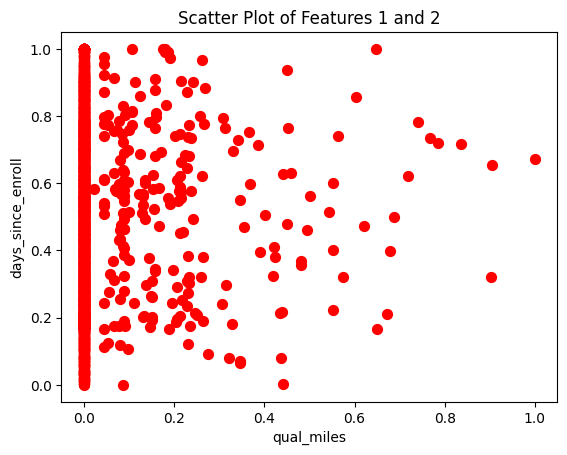

In [25]:
# Initialize parameters

X = datosAerolineas_escalados.drop('award', axis=1)
y = datosAerolineas_escalados['award']
X_2d = X.iloc[:,[1,9]]
print(f'este es las cáracteriísticas evaluadas {X_2d}')
X_2d = X_2d.to_numpy()

# Scatter plot of first two features
plt.scatter(X_2d[:, 0], X_2d[:, 1], marker='o', color='r', s=50)
plt.xlabel('qual_miles')
plt.ylabel('days_since_enroll')
plt.title('Scatter Plot of Features 1 and 2')
plt.show()


In [26]:
K = 3  # Number of clusters
n, d = X_2d.shape
epsilon = 1e-6  # Small value to prevent log(0)
# Mixing coefficients (initial uniform distribution)
pi = np.ones(K) / K
# Initialize means using random samples from data
random_indices = np.random.choice(n, K, replace=False)
mu = X_2d[random_indices, :]

In [27]:
# Function to generate a positive definite covariance matrix
def generate_positive_definite_matrix(d):
    A = np.random.randn(d, d)
    return np.dot(A, A.T) + np.eye(d) * epsilon  # Add identity for stability

# Initialize covariance matrices
Sigma = np.array([generate_positive_definite_matrix(d) for _ in range(K)])

In [28]:
# Ensure covariance matrix is positive definite
def ensure_positive_definite(Sigma):
    return Sigma + np.eye(Sigma.shape[0]) * epsilon

In [29]:
# Expectation Step (E-step)
def expectation_step(X, mu, Sigma, pi):
    """ Compute responsibilities (γ) given current parameters. """
    gamma = np.zeros((n, K))
    print("Este es el valor de Gama", gamma)
    for k in range(K):
        try:
            gamma[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=ensure_positive_definite(Sigma[k]))
        except np.linalg.LinAlgError:
            print(f"Warning: Fixing singular covariance matrix for cluster {k}")
            Sigma[k] = ensure_positive_definite(Sigma[k])
            gamma[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k])

    gamma += epsilon  # Prevents division by zero
    gamma /= gamma.sum(axis=1, keepdims=True)  # Normalize
    return gamma

In [30]:
# Maximization Step (M-step)
def maximization_step(X, gamma):
    """ Update parameters based on responsibilities. """
    Nk = gamma.sum(axis=0)  # Effective cluster size
    pi_new = Nk / n  # Update mixing coefficients
    mu_new = np.dot(gamma.T, X) / Nk[:, np.newaxis]  # Update means

    Sigma_new = np.zeros((K, d, d))
    for k in range(K):
        X_centered = X - mu_new[k]
        Sigma_new[k] = np.dot(gamma[:, k] * X_centered.T, X_centered) / Nk[k]
        Sigma_new[k] = ensure_positive_definite(Sigma_new[k])  # Ensure positive definiteness

    return pi_new, mu_new, Sigma_new

In [31]:
# Compute Log-Likelihood
def compute_log_likelihood(X, pi, mu, Sigma):
    """ Compute the Log-Likelihood to monitor convergence. """
    log_likelihood = 0
    for k in range(K):
        try:
            prob = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=ensure_positive_definite(Sigma[k]))
            prob += epsilon  # Prevents log(0)
            log_likelihood += np.sum(np.log(prob))
        except np.linalg.LinAlgError:
            print(f"Warning: Fixing covariance matrix for cluster {k}")
            Sigma[k] = ensure_positive_definite(Sigma[k])
            prob = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k]) + epsilon
            log_likelihood += np.sum(np.log(prob))

    return log_likelihood

Este es el valor de Gama [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Iteration 1, Log-Likelihood: 2913.3025
Este es el valor de Gama [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Iteration 2, Log-Likelihood: 2647.5217
Este es el valor de Gama [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Iteration 3, Log-Likelihood: 2230.0933
Este es el valor de Gama [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Iteration 4, Log-Likelihood: 691.1080
Este es el valor de Gama [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Iteration 5, Log-Likelihood: -1627.3812
Este es el valor de Gama [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Iteration 6, Log-Likelihood: -637.7613
Este es el valor de Gama [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Iteration 7, Log-Likelihood: -754.1574
Este e

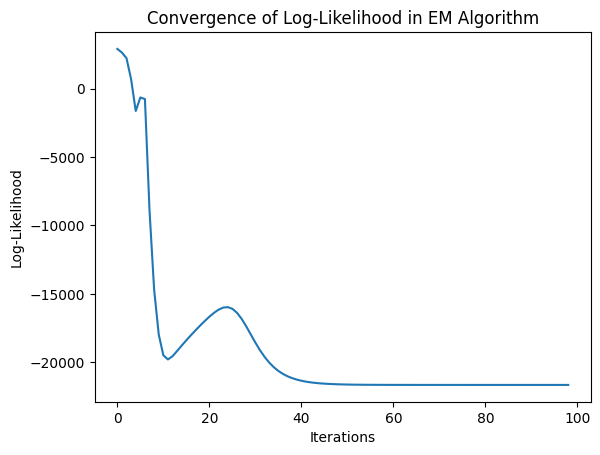

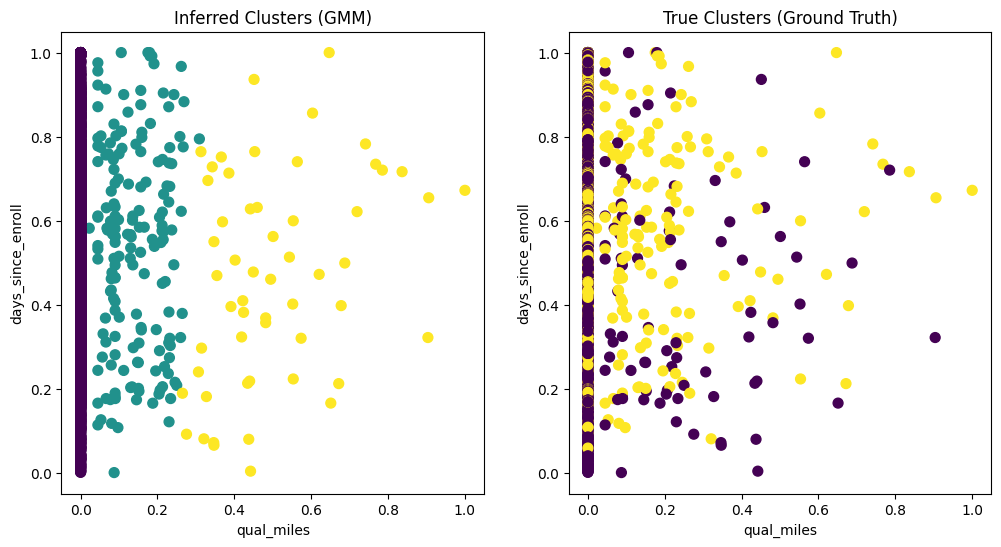

In [32]:
# EM Algorithm for GMM
max_iters = 100  # Maximum iterations
tol = 1e-4  # Convergence threshold
log_likelihoods = []
prev_log_likelihood = -np.inf  # Initialize with a very low value

for i in range(max_iters):
    gamma = expectation_step(X_2d, mu, Sigma, pi)
    pi, mu, Sigma = maximization_step(X_2d, gamma)

    # Compute log-likelihood
    log_likelihood = compute_log_likelihood(X_2d, pi, mu, Sigma)
    log_likelihoods.append(log_likelihood)

    print(f"Iteration {i+1}, Log-Likelihood: {log_likelihood:.4f}")

    # Check for convergence
    if np.abs(log_likelihood - prev_log_likelihood) < tol:
        print(f"Converged at iteration {i+1}.")
        break
    prev_log_likelihood = log_likelihood

# Plot log-likelihood evolution
plt.plot(log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Convergence of Log-Likelihood in EM Algorithm')
plt.show()

# Assign cluster labels based on maximum responsibility
Z = np.argmax(gamma, axis=1)

# Visualization: True vs Predicted Clusters
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# Plot predicted clusters
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], marker='o', c=Z, s=50, cmap='viridis')
ax[0].set_xlabel('qual_miles')
ax[0].set_ylabel('days_since_enroll')
ax[0].set_title('Inferred Clusters (GMM)')

# Plot ground truth clusters
ax[1].scatter(X_2d[:, 0], X_2d[:, 1], marker='o', c=y, s=50, cmap='viridis')
ax[1].set_xlabel('qual_miles')
ax[1].set_ylabel('days_since_enroll')
ax[1].set_title('True Clusters (Ground Truth)')

plt.show()

En la interpretación de la gráfica de la convergencia por log-likelihood, en donde vemos que la verosimiltud tiene una curva alta pero se detalla varios picos, sin embargo podemos observar que la agrupación inferida por el modelo GMM con unos 3 clusters y la gra´fica de la derecha nos muestra que los verdaderos clusters son dos pero vemos que no se ve una clara agrupaciones de los clusters, lo cául recomendamos que se podría realizar tecnicas de PCA para ver una mejor segmentación de los clusters

In [33]:
from sklearn.metrics import rand_score
print(rand_score(y, Z))


0.5426038850883306


Este valor de 0.5426 nos indica que hay una  similitud moderada entre las etiquetas verdaderas y las etiquetas predichas, siendo un resultado moderado y que posiblemente este haciendo predicciones acertadas.

### Parte 2

Se definio la semilla

In [34]:
SEED = 42
datosAerolineas_escalados.head()

balance  qual_miles  cc1_miles  cc2_miles  cc3_miles  bonus_miles  \
0  0.016508         0.0       0.00        0.0        0.0     0.000660   
1  0.011288         0.0       0.00        0.0        0.0     0.000815   
2  0.024257         0.0       0.00        0.0        0.0     0.015636   
3  0.008667         0.0       0.00        0.0        0.0     0.001896   
4  0.057338         0.0       0.75        0.0        0.0     0.164211   

   bonus_trans  flight_miles_12mo  flight_trans_12  days_since_enroll  award  
0     0.011628           0.000000         0.000000           0.843742    0.0  
1     0.023256           0.000000         0.000000           0.839884    0.0  
2     0.046512           0.000000         0.000000           0.847842    0.0  
3     0.011628           0.000000         0.000000           0.837955    0.0  
4     0.302326           0.067398         0.075472           0.835905    1.0

Se vuelve a gráficar para ver las distribuciones de nuestros datos

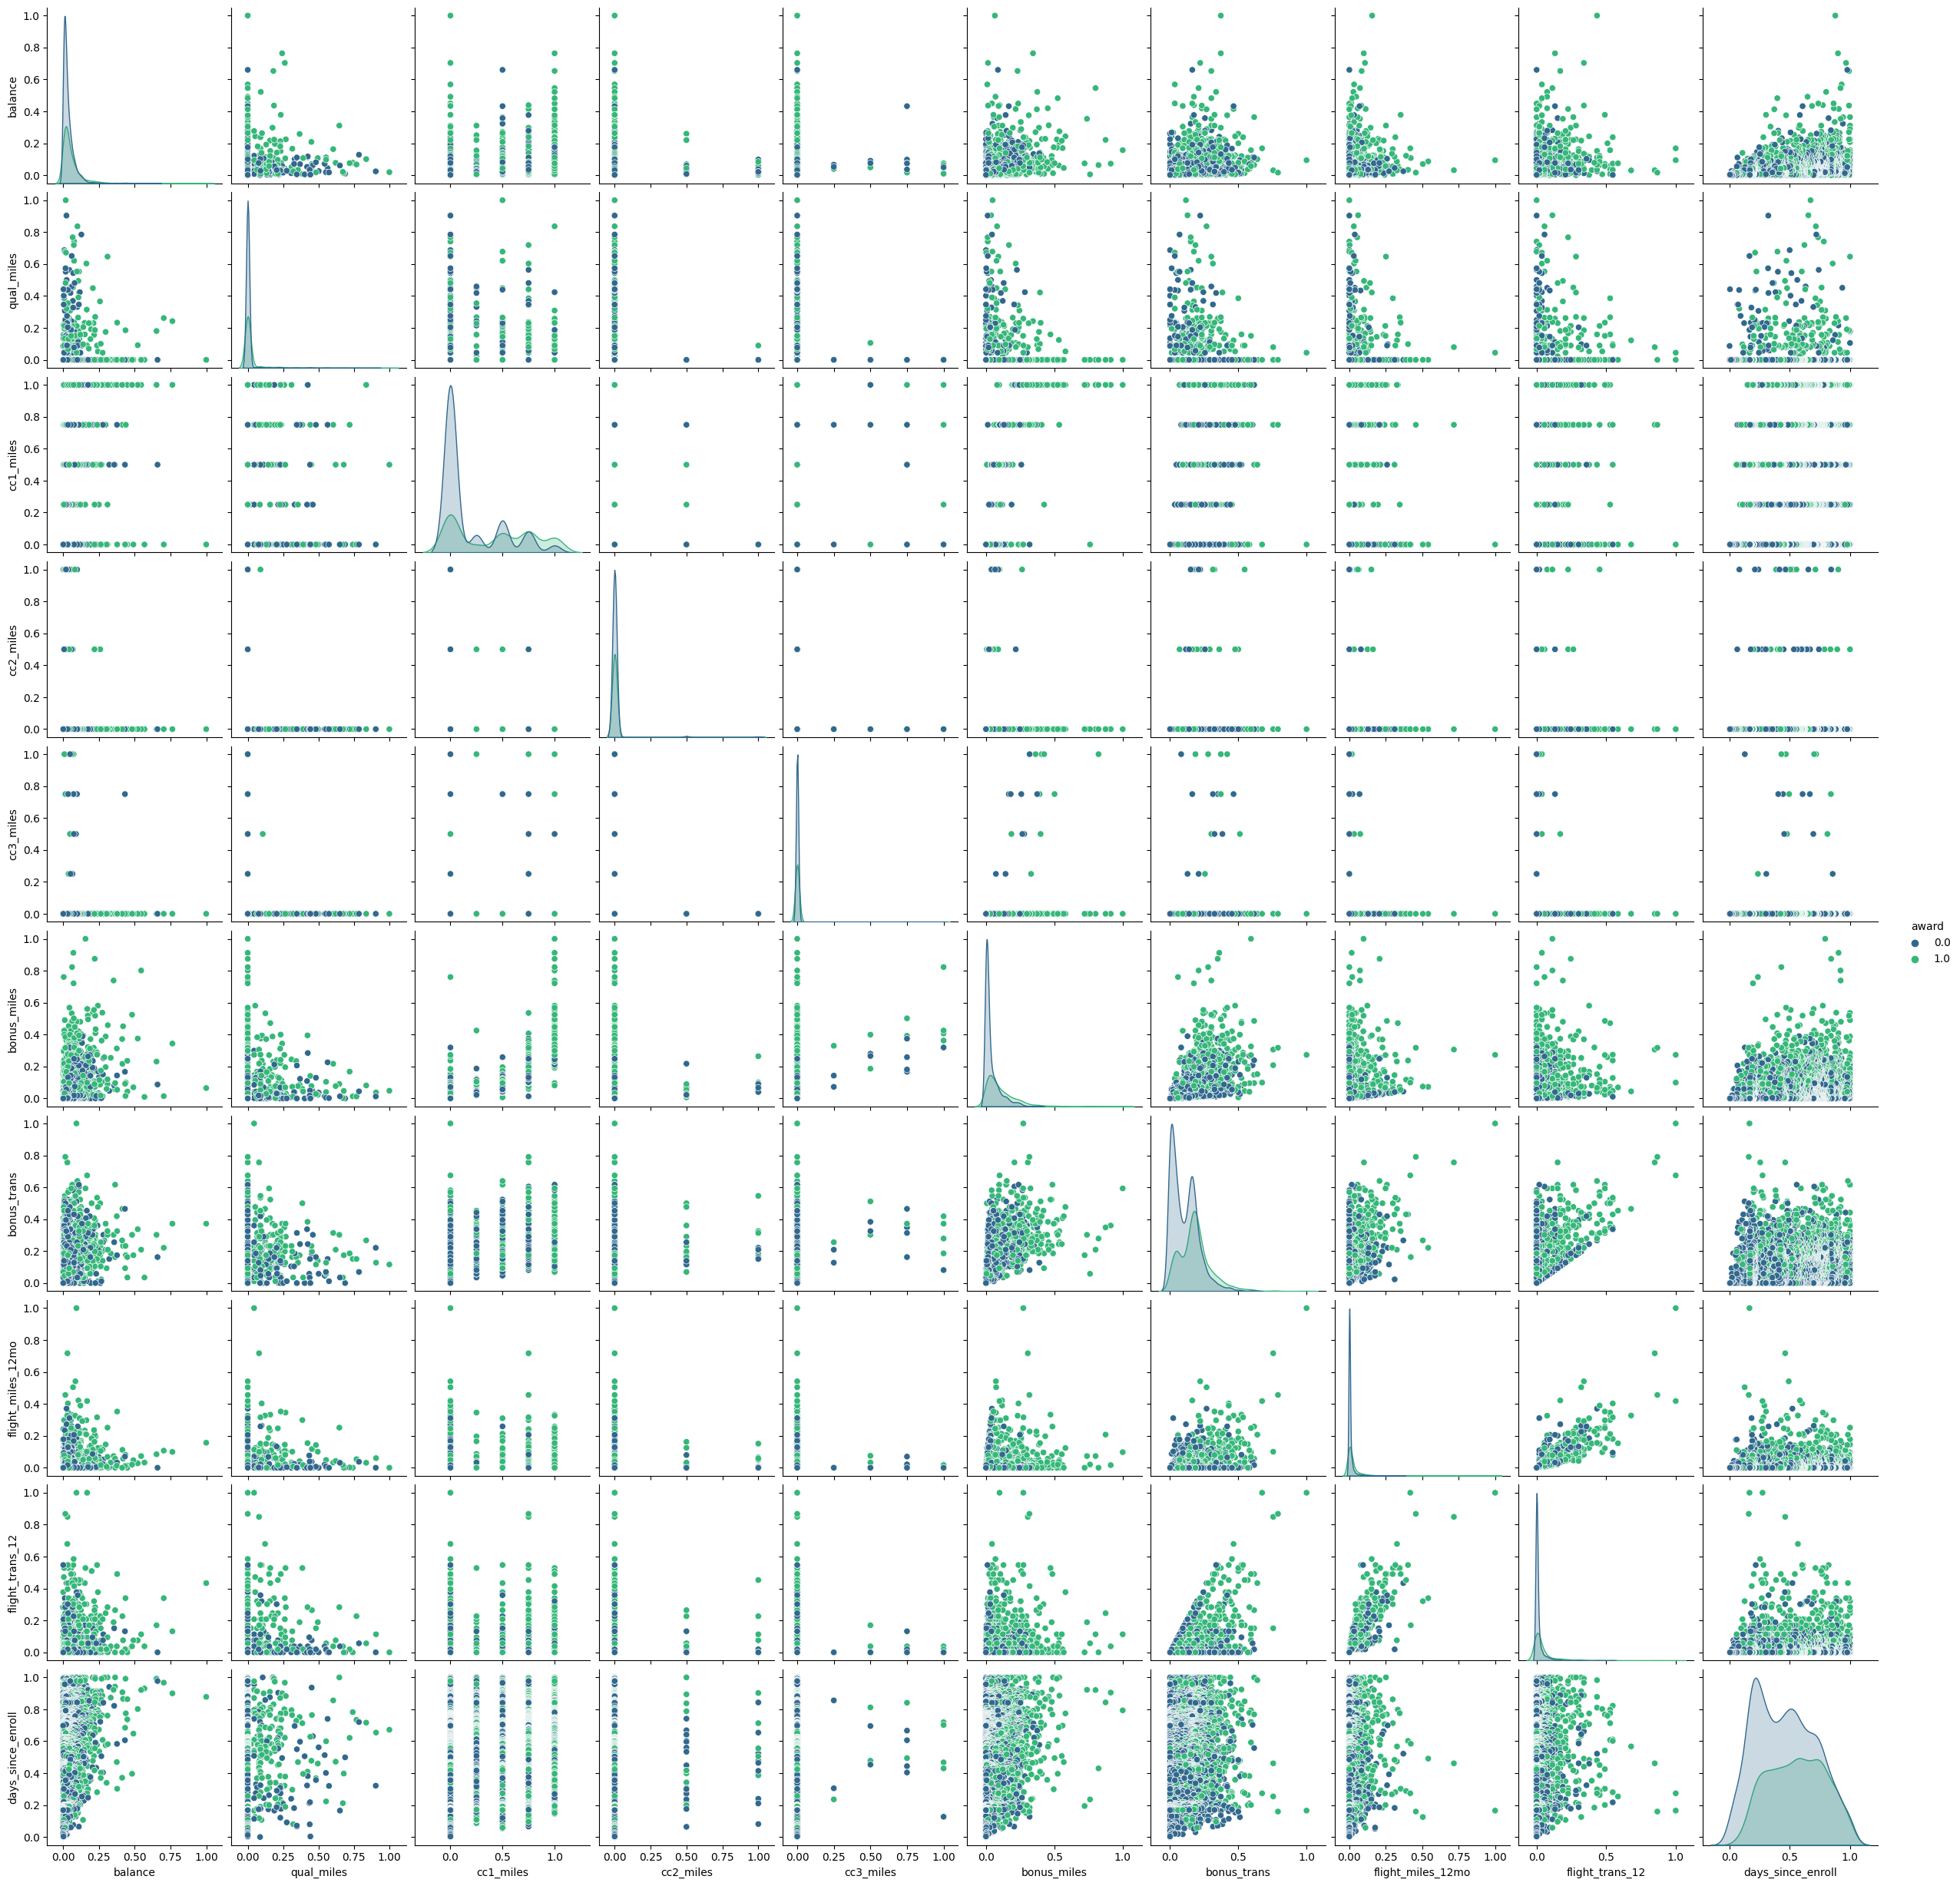

In [35]:
sns.pairplot(datosAerolineas_escalados, hue="award", palette='viridis')

Determinar el número optimo de clusters por método silueta

In [36]:
# Con nuestro dataset establecido y escalado procedemos a implementar el metodo del codo y
# la silueta para determinar el numero optimo de clusters

def scatter_plot(X, y=None):
  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots(figsize=(7, 4))

  if y is None:
    ax.scatter(X[:, 1], X[:, 9], marker=".", s=10)
  else:
    ax.scatter(X[:, 1], X[:, ], marker=".", s=10, c=y)

  ax.set_xlabel("$x_1$", fontsize=14)
  ax.set_ylabel("$x_2$", fontsize=14)
  ax.tick_params(axis='both', labelsize=8)

  ax.grid(False)
  plt.tight_layout()

  plt.savefig("scatter.png", dpi=600, transparent=True)

  plt.show()

Función del modelo Kmeans

In [37]:
def train_kmeans(X):
    ks = np.linspace(2, 8, 7, dtype=np.int64)  # Generaremos 7 clusters de 2 a 8
    inertias = []
    silhouettes = []
    davies_bouldin = []
    kmeans_k = []

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=SEED)
        kmeans.fit(X)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))
        davies_bouldin.append(davies_bouldin_score(X, kmeans.labels_))
        kmeans_k.append(kmeans)

    return kmeans_k, inertias, silhouettes, davies_bouldin, ks

Llamar función

In [38]:
kmeans_k, inertias, silhouettes, davies_bouldin_knn, ks = train_kmeans(datosAerolineas_escalados)

In [39]:
def print_kmeans_results(kmeans_k, inertias, silhouettes, davies_bouldin, ks):
    print("\nResultados de KMeans:")
    print("{:^10} {:^15} {:^15} {:^20}".format("Clusters", "Inertia", "Silhouette", "Davies-Bouldin Index"))
    print("-" * 60)
    for i in range(len(ks)):
        print("{:^10} {:^15.2f} {:^15.4f} {:^20.4f}".format(ks[i], inertias[i], silhouettes[i], davies_bouldin[i]))

print_kmeans_results(kmeans_k, inertias, silhouettes, davies_bouldin_knn, ks)


Resultados de KMeans:
 Clusters      Inertia       Silhouette    Davies-Bouldin Index
------------------------------------------------------------
    2          823.68          0.5359             0.8228       
    3          625.18          0.4646             0.8332       
    4          436.72          0.4745             0.8902       
    5          409.84          0.4362             0.9931       
    6          324.26          0.4329             0.9627       
    7          290.47          0.3926             1.0980       
    8          270.90          0.3921             1.0517       


Gráficamos método de codo

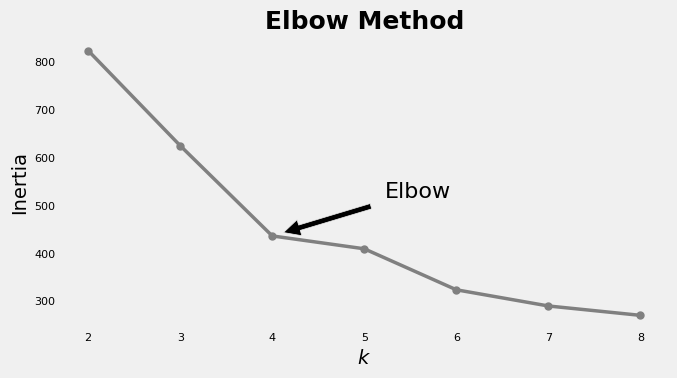

In [40]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks, inertias, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Inertia", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Elbow Method", fontsize=18, fontweight="bold")
ax.grid(False)

ax.annotate("Elbow",
            xy=(4, inertias[2]),
            xytext=(0.55, 0.45),
            textcoords="figure fraction",
            fontsize=16,
            arrowprops=dict(facecolor="black", shrink=0.1)
            )

plt.tight_layout()
plt.savefig("elbow_aerolineas.png", dpi=600, transparent=True)
plt.show()

Gráficamos silueta

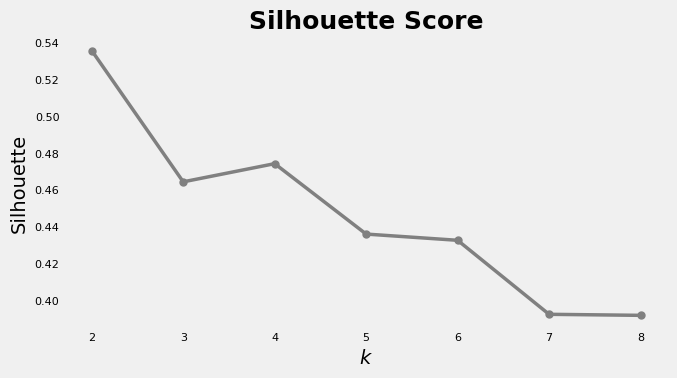

In [41]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks, silhouettes, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Silhouette", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Silhouette Score", fontsize=18, fontweight="bold")
ax.grid(False)



plt.tight_layout()
plt.savefig("silhouette_score_Aerolineas.png", dpi=600, transparent=True)
plt.show()

Al detallar las gráficamos anteriores podemos saber con mayor certeza la cantidad de clusters más optimo a partir de nuestros datos, cabe recalcar que por silueta podemos ver que tiene mejor score agrupaciones entre 2 a 4 cluster  y por el codo nos menciona que podria ser 4 el más optimo

For n_clusters = 3 The average silhouette_score is : 0.4646127065079619
For n_clusters = 4 The average silhouette_score is : 0.4744941579482721
For n_clusters = 5 The average silhouette_score is : 0.43623735714822565
For n_clusters = 6 The average silhouette_score is : 0.43285287948445184


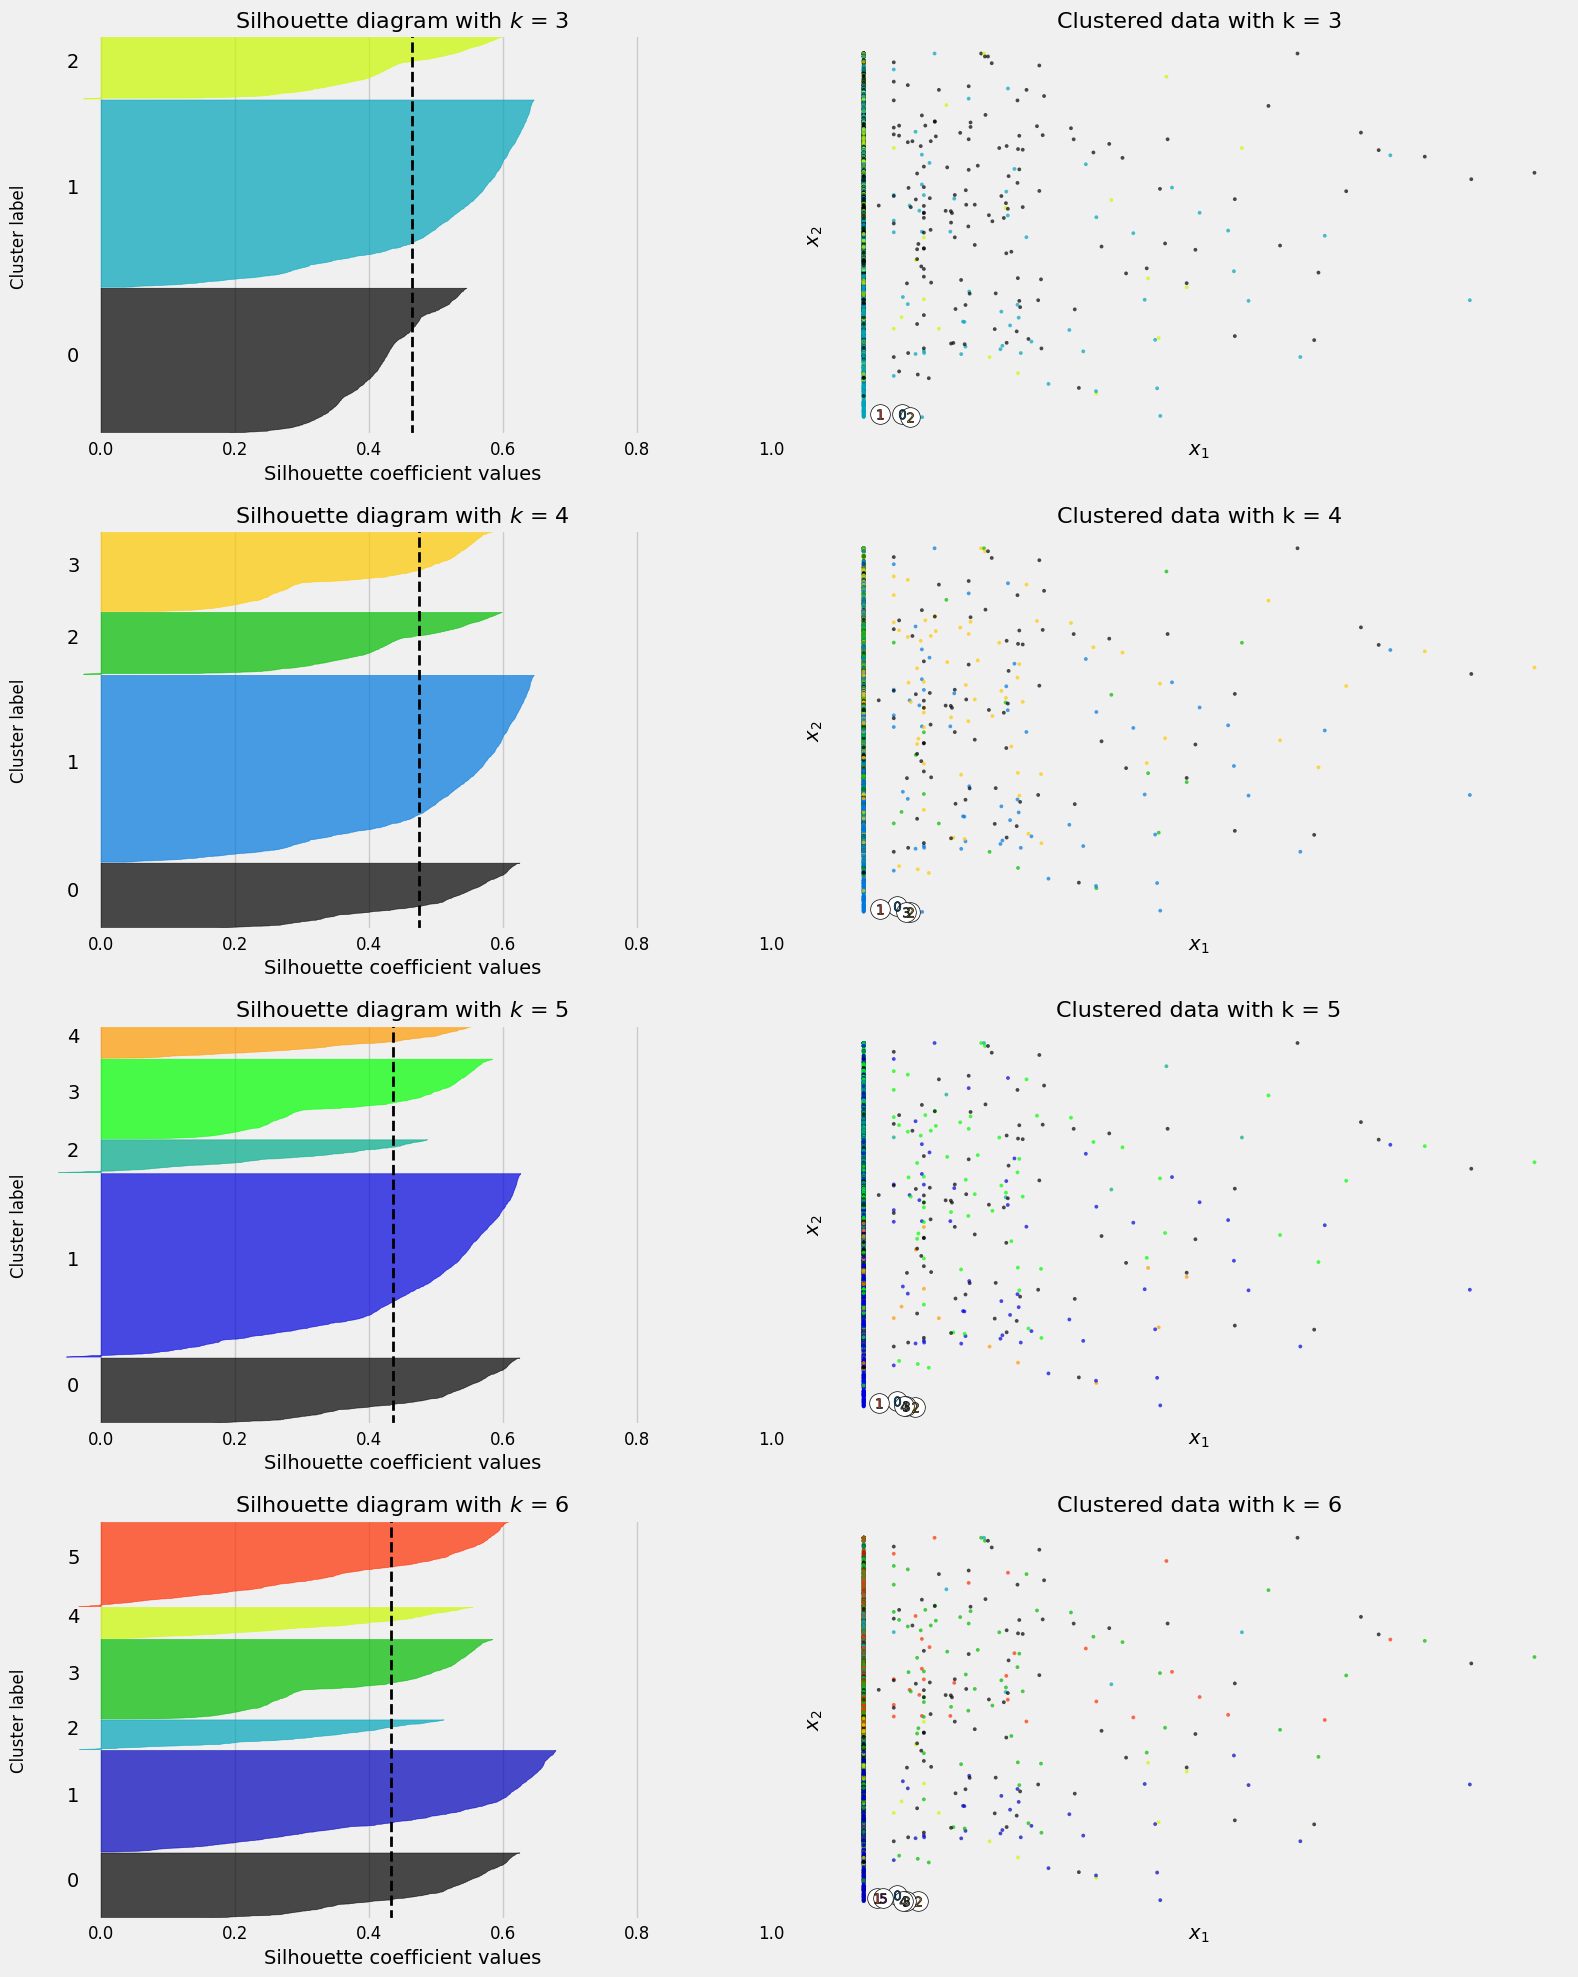

In [42]:
range_n_clusters = [3, 4, 5, 6]

fig, ax = plt.subplots(4, 2, figsize=(16, 20))



for row, n_clusters in enumerate(range_n_clusters):

  # Create a subplot with 1 row and 2 columns
  # fig, (ax1, ax2) = plt.subplots(1, 2)

  # fig.set_size_inches(12, 6)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax[row, 0].set_xlim([-0.1, 1])

  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax[row, 0].set_ylim([0, len(datosAerolineas_escalados) + (n_clusters + 1) * 10])

  # get predictions for each label
  cluster_labels = kmeans_k[n_clusters-2].predict(datosAerolineas_escalados)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(datosAerolineas_escalados, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette score for each sample
  sample_silhouette_values = silhouette_samples(datosAerolineas_escalados, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax[row, 0].fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax[row, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax[row, 0].set_title("Silhouette diagram with $k$ = {}".format(n_clusters), fontsize=16)
  ax[row, 0].set_xlabel("Silhouette coefficient values", fontsize=14)
  ax[row, 0].set_ylabel("Cluster label", fontsize=12)

  ax[row, 0].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  ax[row, 0].tick_params(axis='both', which='major', labelsize=12)

  # The vertical line for average silhouette score of all the values
  ax[row, 0].axvline(x=silhouette_avg, color="black", linestyle="--", linewidth=2)

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax[row, 1].scatter(datosAerolineas_escalados.iloc[:, 1], datosAerolineas_escalados.iloc[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                     c=colors, edgecolor='k')

  # Labeling the clusters
  centers = kmeans_k[n_clusters-2].cluster_centers_
  # Draw white circles at cluster centers
  ax[row, 1].scatter(centers[:, 0], centers[:, 3], marker='o',
                     c="white", alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
    ax[row, 1].scatter(c[0], c[3], marker='$%d$' % i, alpha=1,
                       s=50, edgecolor='k')

  ax[row, 1].set_title(f"Clustered data with k = {n_clusters}", fontsize=16)
  ax[row, 1].set_xlabel("$x_1$", fontsize=14)
  ax[row, 1].set_ylabel("$x_2$", fontsize=14)
  ax[row, 1].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 1].set_xticks([])

  ax[row, 1].grid(False)

  # fig.suptitle(("Silhouette analysis for KMeans clustering "
  # "with $k$ = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("silhouette_diagram_aerolinea.png", dpi=650, transparent=False)
plt.show()

En está gráfica detallamos para cada caso como es que se agrupan los datos dependiendo de la cantidad de clusters pero tambíen se observa que los datos tiene varianzas altas ya que en esos clústers están más dispersos o alejados del centroide del clúster los puntos

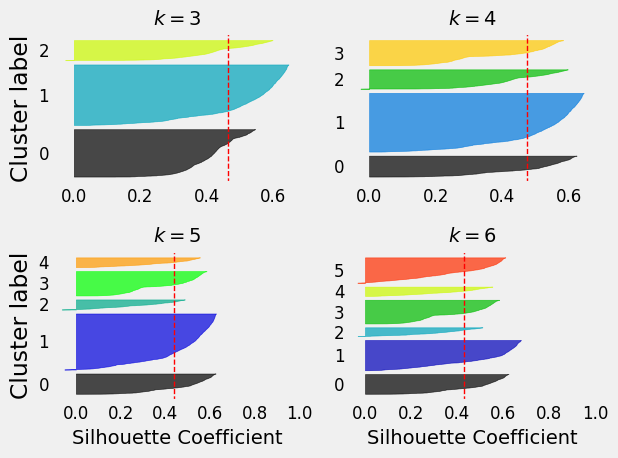

In [43]:

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(datosAerolineas_escalados, y_pred)

    padding = len(datosAerolineas_escalados) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.nipy_spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster label")

    if k in (5, 6):
      plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
      plt.xlabel("Silhouette Coefficient", fontsize=14)
    # else:
    #     plt.tick_params(labelbottom=False)
    plt.tick_params(labelsize=12)
    plt.axvline(x=silhouettes[k - 2], color="red", linestyle="--", linewidth=1)
    plt.title("$k={}$".format(k), fontsize=14, fontweight="bold")

    plt.grid(False)

plt.tight_layout()
plt.show()

Aqui vémos de forma más explicita los clusters y cada una de esos subgraficas nos indica el tema de silhouette score vemos que los cluster 3 a cluster 4 son los que tienen mayor score siendo las mejores ya que estan los datos mejor agrupados

Selección de las feature

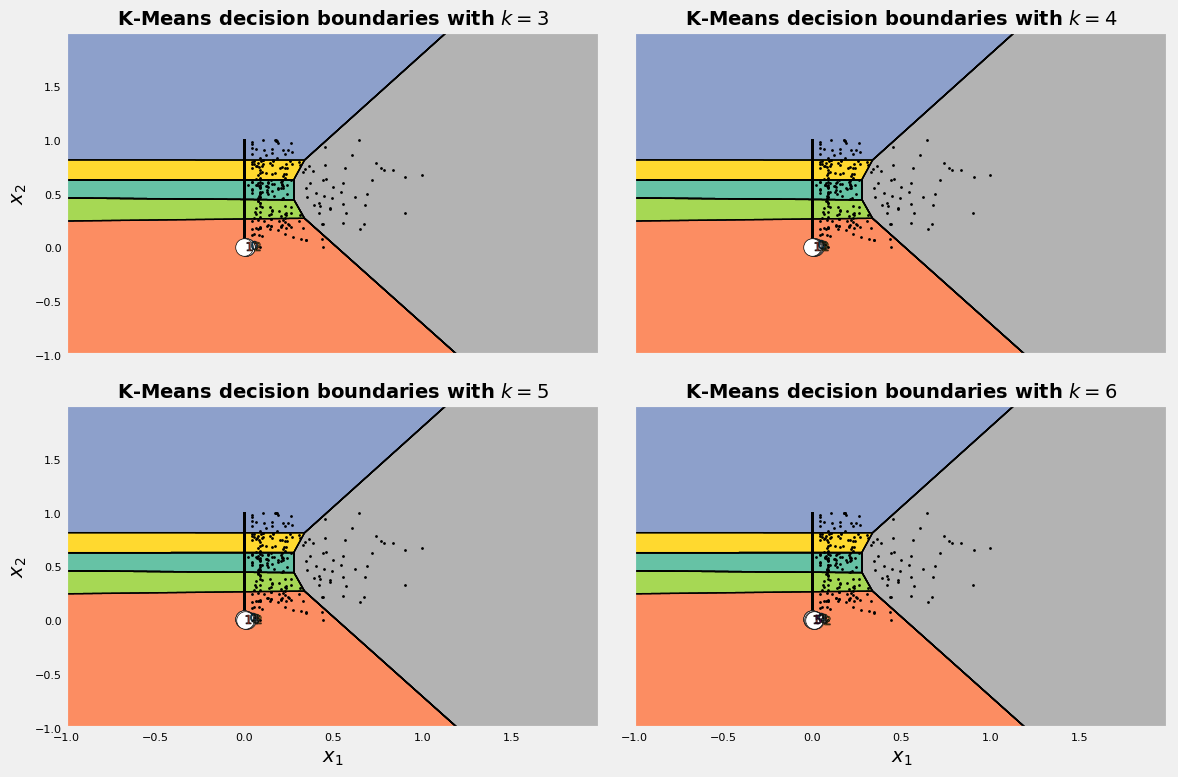

In [44]:
# Seleccionamos dos features relevantes
X_2d = datosAerolineas_escalados[['qual_miles', 'days_since_enroll']]
# Entrenar KMeans en este subconjunto
kmeans_2d = KMeans(n_clusters=k, random_state=SEED)
kmeans_2d.fit(X_2d)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .001     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = datosAerolineas_escalados.iloc[:, 1].min() - 1, datosAerolineas_escalados.iloc[:, 9].max() + 1
y_min, y_max = datosAerolineas_escalados.iloc[:, 1].min() - 1, datosAerolineas_escalados.iloc[:, 9].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# [0, 0] [0, 1]
# [1, 0] [1, 1]

for i, j, k in zip([0, 0, 1, 1], [0, 1, 0, 1], [3, 4, 5, 6]):

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans_2d.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  ax[i, j].contourf(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap="Set2")
  ax[i, j].contour(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              linewidths=1, colors='k')

  ax[i, j].plot(datosAerolineas_escalados.iloc[:, 1], datosAerolineas_escalados.iloc[:, 9], 'k.', markersize=2)

  centers = kmeans_k[k-2].cluster_centers_
  ax[i, j].scatter(centers[:, 3], centers[:, 4], marker='o',
                  c="white", alpha=1, s=160, edgecolor='k', zorder=5)
  for cluster_idx, c in enumerate(centers):
    ax[i, j].scatter(c[0], c[1], marker='$%d$' % cluster_idx, alpha=1,
                    s=40, edgecolor='k', zorder=10)

  ax[i, j].set_title("K-Means decision boundaries with $k = {}$".format(k),
                    fontsize=14, fontweight="bold")

  if k % 2 == 1:
    ax[i, j].set_ylabel("$x_2$", fontsize=14)

  if k >= 5:
    ax[i, j].set_xlabel("$x_1$", fontsize=14)

  ax[i, j].tick_params(axis='both', labelsize=8)

  ax[i, j].grid(False)

plt.tight_layout()
plt.savefig("decision_boundaries_aerolinea.png", dpi=800, transparent=True)
plt.show()

### Conclusiones Knn
Para el dataset limpio y bajo la iteración con rango de clusters de 2 a 8, se observa que para 2 clusters se tiene una inercia de 823.68, un índice de silueta de 0.5359 y un indice de Davies-Bouldin de 0.8228, generando el mejor escenario bajo estas métricas, esto da evidencia del nivel de aproximación entre los puntos dando indicio de que no existen grupos dentro de esta combinación de variables. De allí se observa que a medida que aumentan los clusters se disminuye el indice de silueta y la inercia (lo que indica que los puntos están más cerca de sus centroides, pero con alto solapamiento), mientras que el indice de Davies-Bouldin aumenta indicando que los clusters son menos definidos y de menor calidad. No obstante, cuando nos dirigimos al método del codo y del diagrama de silueta, nos muestra que podemos clusterizar el conjunto de variables de 4 grupos, esto dado que el método del codo muestra que el mejor escenario es con 4 grupos al igual que el de silueta, ya que están cercas seleccionamos los grupos propuestos desde el score de silueta.



### GMM

In [45]:
def train_gmm(X):
    ks_gmm = np.linspace(2, 8, 7, dtype=np.int64)  # Generamos 7 modelos GMM con k de 2 a 8
    bics = []
    silhouettes = []
    davies_bouldin = []
    gmm_models = []

    for k in ks_gmm:
        gmm = GaussianMixture(n_components=k, random_state=SEED)
        gmm.fit(X)

        # Se calcula el BIC; mientras menor sea, mejor se ajusta el modelo
        bic_val = gmm.bic(X)
        bics.append(bic_val)

        # Se obtienen las etiquetas para cada punto y se calcula el coeficiente de silueta
        labels = gmm.predict(X)
        silhouette_val = silhouette_score(X, labels)
        silhouettes.append(silhouette_val)

        # Se calcula Davies-Bouldin Index
        dbi_val = davies_bouldin_score(X, labels)
        davies_bouldin.append(dbi_val)

        gmm_models.append(gmm)

    return gmm_models, bics, silhouettes, davies_bouldin, ks_gmm

In [46]:
gmm_models, bics, silhouettes, davies_bouldin_gmm, ks_gmm = train_gmm(datosAerolineas_escalados)

In [47]:
def print_gmm_results(gmm_models, bics, silhouettes, davies_bouldin, ks_gmm):
    print("\nResultados de GMM:")
    print("{:^10} {:^15} {:^15} {:^20}".format("Clusters", "BIC", "Silhouette", "Davies-Bouldin Index"))
    print("-" * 60)
    for i in range(len(ks_gmm)):
        print("{:^10} {:^15.2f} {:^15.4f} {:^20.4f}".format(ks_gmm[i], bics[i], silhouettes[i], davies_bouldin[i]))

print_gmm_results(gmm_models, bics, silhouettes, davies_bouldin_gmm, ks_gmm)


Resultados de GMM:
 Clusters        BIC         Silhouette    Davies-Bouldin Index
------------------------------------------------------------
    2        -143120.25        0.5359             0.8228       
    3        -175149.97        0.3538             1.1969       
    4        -213259.28        0.2670             2.9672       
    5        -234573.30        0.1345             4.0225       
    6        -253985.48        0.2129             3.1090       
    7        -268254.44        0.1839             2.3480       
    8        -270687.79        0.1981             2.7412       


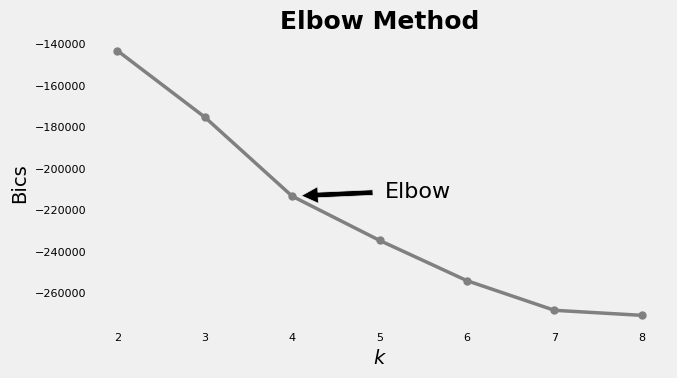

In [48]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks_gmm, bics, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Bics", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Elbow Method", fontsize=18, fontweight="bold")
ax.grid(False)

ax.annotate("Elbow",
            xy=(4, bics[2]),
            xytext=(0.55, 0.45),
            textcoords="figure fraction",
            fontsize=16,
            arrowprops=dict(facecolor="black", shrink=0.1)
            )

plt.tight_layout()
plt.savefig("elbow2aerolinea.png", dpi=600, transparent=True)
plt.show()

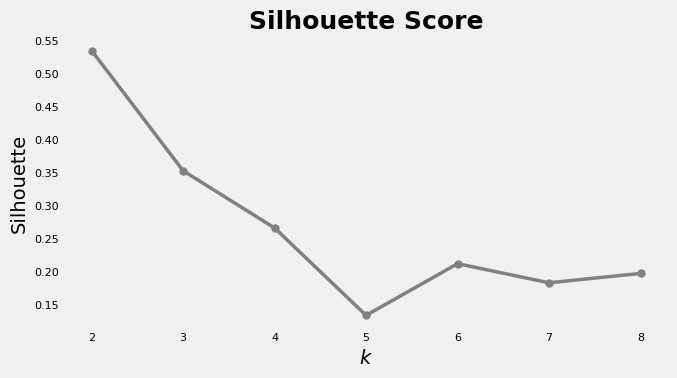

In [49]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks_gmm, silhouettes, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Silhouette", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Silhouette Score", fontsize=18, fontweight="bold")
ax.grid(False)


plt.tight_layout()
plt.savefig("silhouette_score2aerolineas.png", dpi=600, transparent=True)
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.3537612909718156
For n_clusters = 4 The average silhouette_score is : 0.2669935015821507
For n_clusters = 5 The average silhouette_score is : 0.13451943716555273
For n_clusters = 6 The average silhouette_score is : 0.21285680209784968


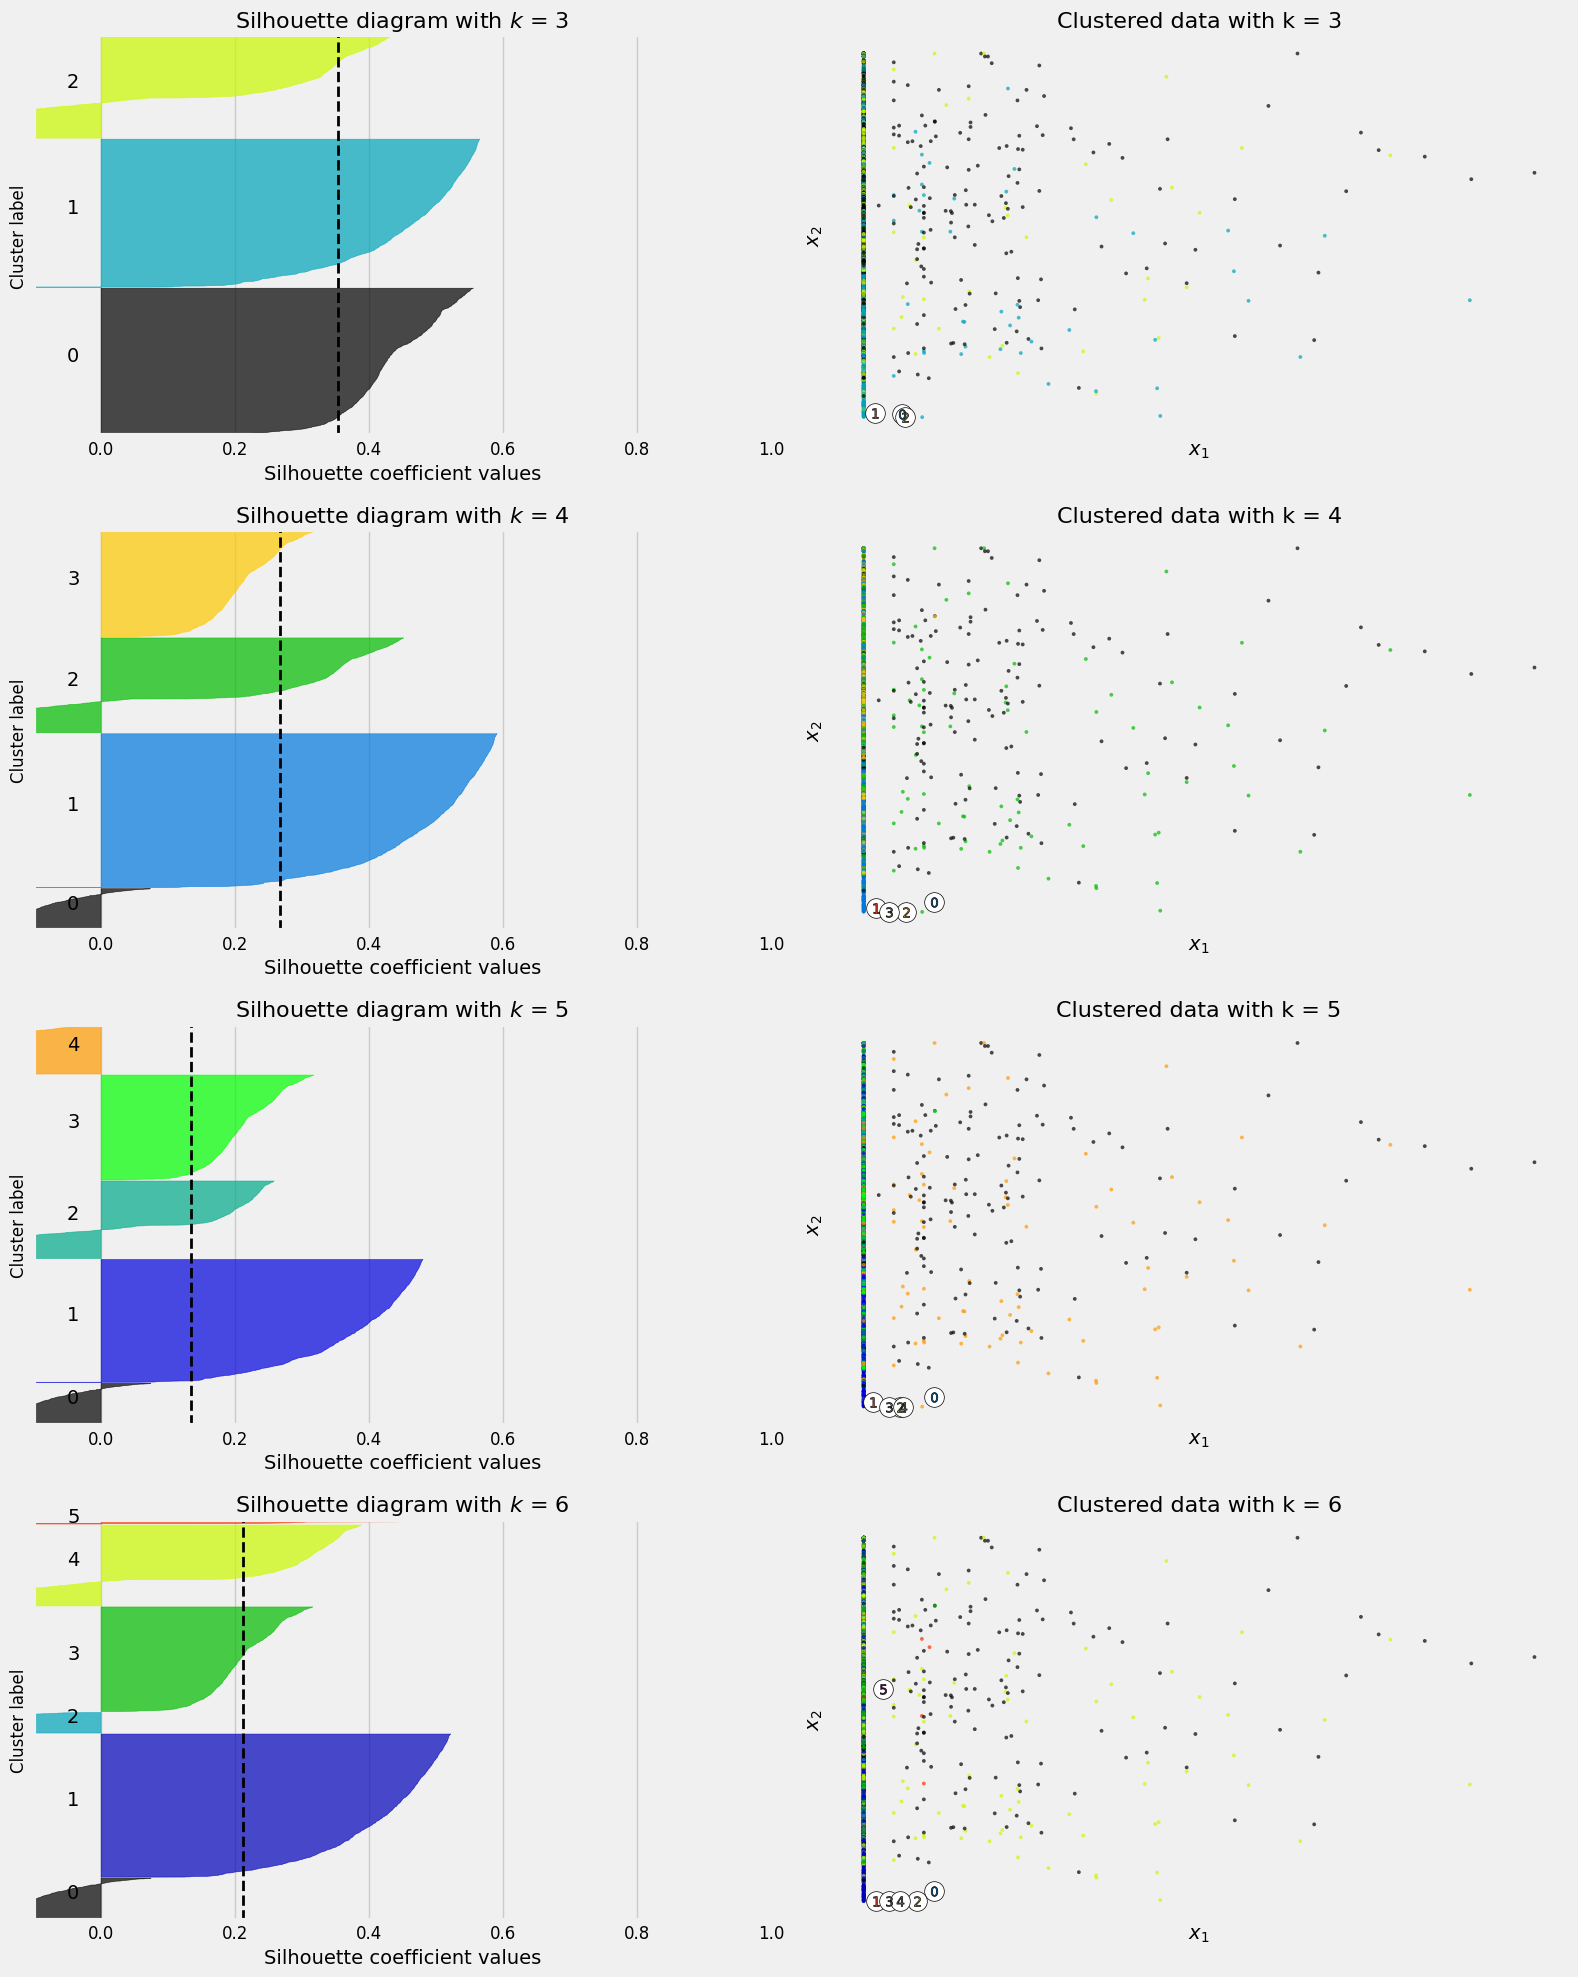

In [50]:
range_n_clusters = [3, 4, 5, 6]

fig, ax = plt.subplots(4, 2, figsize=(16, 20))

# [0, 0] [0, 1]
# [1, 0] [1, 1]
# [2, 0] [2, 1]
# [3, 0] [3, 1]

for row, n_clusters in enumerate(range_n_clusters):

  # Create a subplot with 1 row and 2 columns
  # fig, (ax1, ax2) = plt.subplots(1, 2)

  # fig.set_size_inches(12, 6)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax[row, 0].set_xlim([-0.1, 1])

  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax[row, 0].set_ylim([0, len(datosAerolineas_escalados) + (n_clusters + 1) * 10])

  # get predictions for each label
  cluster_labels = gmm_models[n_clusters-2].predict(datosAerolineas_escalados)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(datosAerolineas_escalados, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette score for each sample
  sample_silhouette_values = silhouette_samples(datosAerolineas_escalados, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax[row, 0].fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax[row, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax[row, 0].set_title("Silhouette diagram with $k$ = {}".format(n_clusters), fontsize=16)
  ax[row, 0].set_xlabel("Silhouette coefficient values", fontsize=14)
  ax[row, 0].set_ylabel("Cluster label", fontsize=12)

  ax[row, 0].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  ax[row, 0].tick_params(axis='both', which='major', labelsize=12)

  # The vertical line for average silhouette score of all the values
  ax[row, 0].axvline(x=silhouette_avg, color="black", linestyle="--", linewidth=2)

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax[row, 1].scatter(datosAerolineas_escalados.iloc[:, 1], datosAerolineas_escalados.iloc[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                     c=colors, edgecolor='k')

  # Labeling the clusters
  centers = gmm_models[n_clusters-2].means_
  # Draw white circles at cluster centers
  ax[row, 1].scatter(centers[:, 0], centers[:, 3], marker='o',
                     c="white", alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
    ax[row, 1].scatter(c[0], c[3], marker='$%d$' % i, alpha=1,
                       s=50, edgecolor='k')

  ax[row, 1].set_title(f"Clustered data with k = {n_clusters}", fontsize=16)
  ax[row, 1].set_xlabel("$x_1$", fontsize=14)
  ax[row, 1].set_ylabel("$x_2$", fontsize=14)
  ax[row, 1].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 1].set_xticks([])

  ax[row, 1].grid(False)

  # fig.suptitle(("Silhouette analysis for KMeans clustering "
  # "with $k$ = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("silhouette_diagram2aerolineas.png", dpi=650, transparent=False)
plt.show()

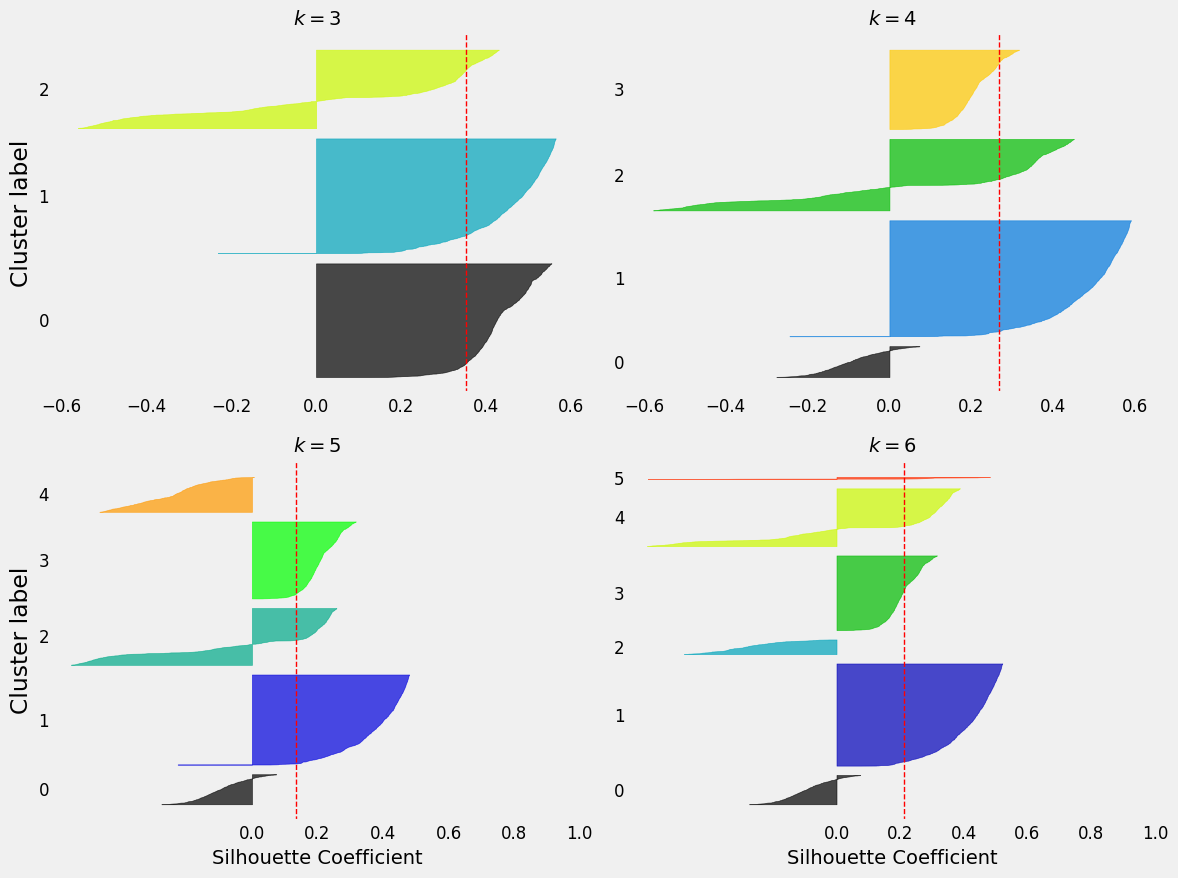

In [51]:
plt.figure(figsize=(12, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = gmm_models[k - 2].predict(datosAerolineas_escalados)
    silhouette_coefficients = silhouette_samples(datosAerolineas_escalados, y_pred)

    padding = len(datosAerolineas_escalados) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.nipy_spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster label")

    if k in (5, 6):
      plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
      plt.xlabel("Silhouette Coefficient", fontsize=14)
    # else:
    #     plt.tick_params(labelbottom=False)
    plt.tick_params(labelsize=12)
    plt.axvline(x=silhouettes[k - 2], color="red", linestyle="--", linewidth=1)
    plt.title("$k={}$".format(k), fontsize=14, fontweight="bold")

    plt.grid(False)

plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 137. MiB for an array with shape (9000000, 2) and data type float64

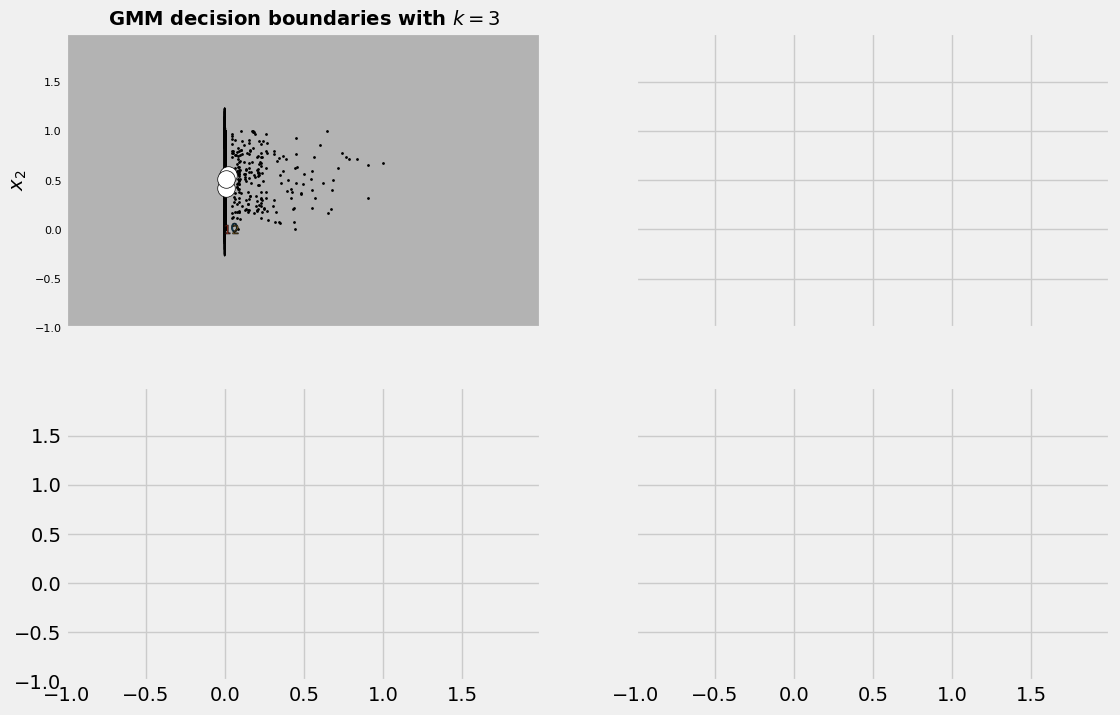

In [52]:
# Seleccionamos dos features relevantes
X_2d = datosAerolineas_escalados[['qual_miles', 'days_since_enroll']]
# Entrenar GMM en este subconjunto

gmm_2d = GaussianMixture(n_components=k, random_state=SEED)
gmm_2d.fit(X_2d)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .001     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = datosAerolineas_escalados.iloc[:, 1].min() - 1, datosAerolineas_escalados.iloc[:, 9].max() + 1
y_min, y_max = datosAerolineas_escalados.iloc[:, 1].min() - 1, datosAerolineas_escalados.iloc[:, 9].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# [0, 0] [0, 1]
# [1, 0] [1, 1]

for i, j, k in zip([0, 0, 1, 1], [0, 1, 0, 1], [3, 4, 5, 6]):

  # Obtain labels for each point in mesh. Use last trained model.
  Z = gmm_2d.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  ax[i, j].contourf(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap="Set2")
  ax[i, j].contour(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              linewidths=1, colors='k')

  ax[i, j].plot(datosAerolineas_escalados.iloc[:, 1], datosAerolineas_escalados.iloc[:, 9], 'k.', markersize=2)

  centers = gmm_models[k-2].means_
  ax[i, j].scatter(centers[:, 1], centers[:, 9], marker='o',
                  c="white", alpha=1, s=160, edgecolor='k', zorder=5)
  for cluster_idx, c in enumerate(centers):
    ax[i, j].scatter(c[0], c[1], marker='$%d$' % cluster_idx, alpha=1,
                    s=40, edgecolor='k', zorder=10)

  ax[i, j].set_title("GMM decision boundaries with $k = {}$".format(k),
                    fontsize=14, fontweight="bold")

  if k % 2 == 1:
    ax[i, j].set_ylabel("$x_2$", fontsize=14)

  if k >= 5:
    ax[i, j].set_xlabel("$x_1$", fontsize=14)

  ax[i, j].tick_params(axis='both', labelsize=8)

  ax[i, j].grid(False)

plt.tight_layout()
plt.savefig("decision_boundaries_aerolinea2.png", dpi=800, transparent=True)
plt.show()